# Post Hoc Explaination on Adult

# Setup

In the following cells we are going to configure our notebook. First, we clone the xai library (Naretto, Bodria) and install the necessary packages with pip. Then we import the libraries that we need

In [1]:
!git clone https://github.com/francescanaretto/XAI-course_2021

Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 1047, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 1047 (delta 47), reused 264 (delta 42), pack-reused 777
Receiving objects: 100% (1047/1047), 561.90 MiB | 18.82 MiB/s, done.
Resolving deltas: 100% (264/264), done.
Checking out files: 100% (465/465), done.


In [2]:
!pip install shap lime deap interpret aix360 bitarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.3 MB/s 
     |████████████████████████████████| 275 kB 41.9 MB/s 
     |████████████████████████████████| 139 kB 61.6 MB/s 
     |████████████████████████████████| 58.3 MB 1.3 MB/s 
     |████████████████████████████████| 241 kB 36.2 MB/s 
     |████████████████████████████████| 8.9 MB 11.9 MB/s 
     |████████████████████████████████| 280 kB 50.0 MB/s 
     |████████████████████████████████| 758 kB 36.1 MB/s 
     |████████████████████████████████| 6.5 MB 35.6 MB/s 
     |████████████████████████████████| 3.6 MB 31.8 MB/s 
     |████████████████████████████████| 9.9 MB 20.5 MB/s 
     |████████████████████████████████| 261 kB 40.5 MB/s 
     |████████████████████████████████| 1.6 MB 37.3 MB/s 
     |████████████████████████████████| 132 kB 52.1 MB/s 
     |████████████████████████████████| 109.7 MB 11 kB/s 
     |██████████████████████████

In [1]:
cd XAI-course_2021/Tabular

/Users/roberto/Documents/Insegnamento/XAI/2024/XAI-course_2021/Tabular


In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics

import lime
import shap
import xgboost as xgb

from xailib.data_loaders.dataframe_loader import prepare_dataframe

from xailib.explainers.lime_explainer import LimeXAITabularExplainer
from xailib.explainers.lore_explainer import LoreTabularExplainer
from xailib.explainers.shap_explainer_tab import ShapXAITabularExplainer

from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Input Data Preparation


We start by reading our data. 

We are going to work on the adult dataset. It is a classic, benchmark tabular dataset, designed for a classification task.

The Adult dataset classifies people as high ($\geq$ 50k) or low ($\leq$50k) income.

We read our data from a .csv file into a `pandas` `DataFrame`.

In [2]:
filename = 'adult_clean.csv'
adult = pd.read_csv(filename, skipinitialspace=True, na_values='?', keep_default_na=True)
adult.head()

age  workclass  fnlwgt  education-num  marital-status  occupation  \
0   39          0   77516             13               7          14   
1   50          1   83311             13               1           1   
2   38          2  215646              9               2           2   
3   53          2  234721              7               1           2   
4   28          2  338409             13               1           3   

   relationship  race  sex  capital-gain  capital-loss  hours-per-week  \
0             5     1    0          2174             0              40   
1             1     1    0             0             0              13   
2             5     1    0             0             0              40   
3             1     2    0             0             0              40   
4             2     2    1             0             0              40   

   native-country  class  
0              41      0  
1              41      0  
2              41      0  
3              41      0  
4               1      0

`class` is our target variable, the one that we want to predict

In [3]:
target = 'class'

We can look at some summary to have an idea of how our data is distributed

In [4]:
adult.describe()

age     workclass        fnlwgt  education-num  \
count  30162.000000  30162.000000  3.016200e+04   30162.000000   
mean      38.437902      2.109343  1.897938e+05      10.121312   
std       13.134665      0.934785  1.056530e+05       2.549995   
min       17.000000      0.000000  1.376900e+04       1.000000   
25%       28.000000      2.000000  1.176272e+05       9.000000   
50%       37.000000      2.000000  1.784250e+05      10.000000   
75%       47.000000      2.000000  2.376285e+05      13.000000   
max       90.000000      6.000000  1.484705e+06      16.000000   

       marital-status    occupation  relationship          race           sex  \
count    30162.000000  30162.000000  30162.000000  30162.000000  30162.000000   
mean         3.332272      6.342749      2.775247      1.211823      0.324315   
std          2.708290      4.127163      1.676177      0.612461      0.468126   
min          1.000000      1.000000      1.000000      1.000000      0.000000   
25%          1.000000      3.000000      1.000000      1.000000      0.000000   
50%          2.000000      5.000000      3.000000      1.000000      0.000000   
75%          7.000000     10.000000      5.000000      1.000000      1.000000   
max          7.000000     14.000000      5.000000      5.000000      1.000000   

       capital-gain  capital-loss  hours-per-week  native-country  \
count  30162.000000  30162.000000    30162.000000    30162.000000   
mean    1092.007858     88.372489       40.931238       38.570420   
std     7406.346497    404.298370       11.979984        8.429816   
min        0.000000      0.000000        1.000000        1.000000   
25%        0.000000      0.000000       40.000000       41.000000   
50%        0.000000      0.000000       40.000000       41.000000   
75%        0.000000      0.000000       45.000000       41.000000   
max    99999.000000   4356.000000       99.000000       41.000000   

              class  
count  30162.000000  
mean       0.248922  
std        0.432396  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [5]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30162 non-null  int64
 1   workclass       30162 non-null  int64
 2   fnlwgt          30162 non-null  int64
 3   education-num   30162 non-null  int64
 4   marital-status  30162 non-null  int64
 5   occupation      30162 non-null  int64
 6   relationship    30162 non-null  int64
 7   race            30162 non-null  int64
 8   sex             30162 non-null  int64
 9   capital-gain    30162 non-null  int64
 10  capital-loss    30162 non-null  int64
 11  hours-per-week  30162 non-null  int64
 12  native-country  30162 non-null  int64
 13  class           30162 non-null  int64
dtypes: int64(14)
memory usage: 3.2 MB


After the data is loaded in memory, we need to extract metadata information to automatically handle the content withint the table.

We can do this on our own, but the loader method `prepare_dataframe` can make a lot of work for us.
The method `prepare_dataframe` scans the table and extract the following information:

- `df`: is a trasformed version of the original dataframe, where discrete attributes are transformed into numerical attributes by using one hot encoding strategy;
- `feature_names`: is a list containint the names of the features after the transformation;
- `class_values`: the list of all the possible values for the class_field column;
- `numeric_columns`: a list of the original features that contain numeric (i.e. continuous) values;
- `rdf`: the original dataframe, before the transformation;
- `real_feature_names`: the list of the features of the dataframe before the transformation;
- `features_map`: it is a dictionary pointing each feature to the original one before the transformation.

In [6]:
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = prepare_dataframe(adult, target)

# Let's train a black box on our data

Now that the data is ready we can train a classifier on it. Let's try the classic `random forest classifier`.


First, we split train and test

In [7]:
test_size = 0.3
random_state = 42
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_names], df[target],
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=df[target])

We can then create our black box and train it. 
We should do some hyper parameter search first, possibly with cross validation, but this is just an example

In [8]:
bb = RandomForestClassifier(n_estimators=20, random_state=random_state)
bb.fit(X_train.values, Y_train.values)
 

RandomForestClassifier(n_estimators=20, random_state=42)

In [9]:
Y_pred = bb.predict(X_train)
print(classification_report(Y_train, Y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15857
           1       1.00      0.98      0.99      5256

    accuracy                           1.00     21113
   macro avg       1.00      0.99      0.99     21113
weighted avg       1.00      1.00      1.00     21113



In [10]:
Y_pred = bb.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6797
           1       0.75      0.60      0.67      2252

    accuracy                           0.85      9049
   macro avg       0.81      0.77      0.79      9049
weighted avg       0.84      0.85      0.85      9049



Obviously, train and test present very different metrics. 
Now we can apply a post-hoc explanation method to our black box. 

I will also train an alternative model, an xgboost classifier. The reason will become clear shortly.

In [11]:
a = 10
arr = np.array(a)
arr.shape == ()

True

In [12]:
arr = np.array([arr])
arr.shape

(1,)

In [13]:
xgbclf = xgb.XGBClassifier().fit(X_train, Y_train)

# SHAP


SHAP uses game theory and shapley values to provide an explanation.

SHAP provides several explanators, optimized for different objectives, and several visualization options.

- Kernel Explainer, it is the *real* agnostic method for computing Shap values. Hence, it works for every kind of ML model (quite slow).
- Linear Explainer, for explaining linear models. It is an exact method. It allows for an analysis with independent variables, as well as for correlated ones (you have to estimates the variables covariance matrix).
- Tree Explainer, for explaining tree-based models (tree and ensambles). Is is an exact algorithm.
- Gradient Explainer, for explaining deep learning models. It is based on Integrated Gradient and it is an approximation algorithm.
- Deep Explainer, for explaining deep learning models. It is based on DEEPLift and the method computes an approximation algorithm (faster than Gradient Explainer).

For our random forest we can use the tree explainer

In [15]:
shap_tree_exp = shap.TreeExplainer(bb)
shap_values_tree = shap_tree_exp.shap_values(X_test[0:200])

In [16]:
shap_values_tree

[array([[ 0.17879572,  0.00326025,  0.02256971, ...,  0.01260453,
          0.00731525,  0.00034689],
        [-0.02386485,  0.001078  ,  0.0154171 , ...,  0.00559461,
          0.01356441, -0.04715191],
        [-0.06277816, -0.007059  ,  0.00675256, ...,  0.01377204,
         -0.00527542, -0.00207131],
        ...,
        [-0.0305281 ,  0.05282899,  0.03481544, ...,  0.01378768,
         -0.0074861 , -0.00257701],
        [-0.08045421, -0.0052237 ,  0.03808235, ...,  0.01216379,
          0.0060524 ,  0.0012001 ],
        [-0.03184666,  0.04611489,  0.01049669, ...,  0.01937486,
         -0.08086313, -0.00056737]]),
 array([[-0.17879572, -0.00326025, -0.02256971, ..., -0.01260453,
         -0.00731525, -0.00034689],
        [ 0.02386485, -0.001078  , -0.0154171 , ..., -0.00559461,
         -0.01356441,  0.04715191],
        [ 0.06277816,  0.007059  , -0.00675256, ..., -0.01377204,
          0.00527542,  0.00207131],
        ...,
        [ 0.0305281 , -0.05282899, -0.03481544, ..., -

The summary plot gives us an overall view of the shapley values for a bunch of records

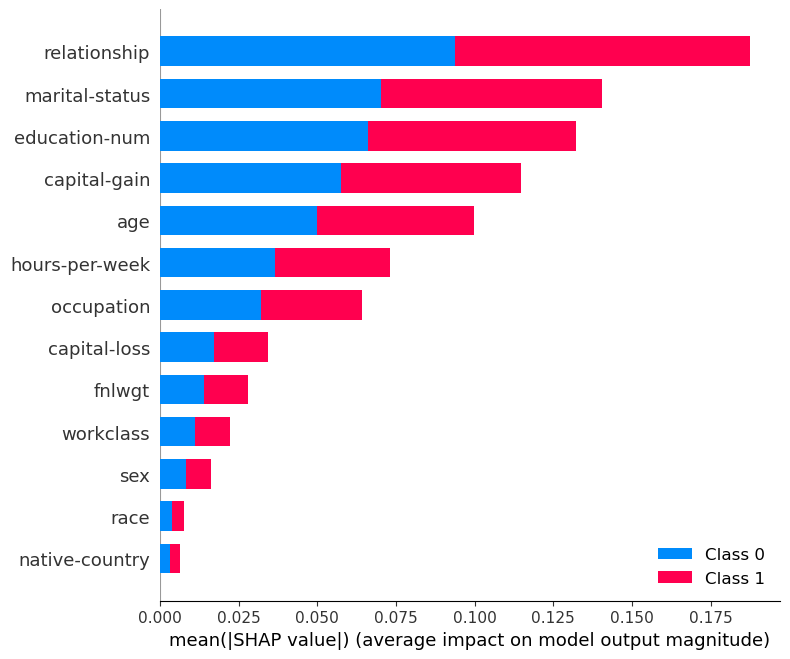

In [17]:
shap.summary_plot(shap_values_tree, X_test[0:200])

In [18]:
tree_explanation_object = shap_tree_exp(X_test[0:200])

In [19]:
tree_explanation_object

.values =
array([[[ 0.17879572, -0.17879572],
        [ 0.00326025, -0.00326025],
        [ 0.02256971, -0.02256971],
        ...,
        [ 0.01260453, -0.01260453],
        [ 0.00731525, -0.00731525],
        [ 0.00034689, -0.00034689]],

       [[-0.02386485,  0.02386485],
        [ 0.001078  , -0.001078  ],
        [ 0.0154171 , -0.0154171 ],
        ...,
        [ 0.00559461, -0.00559461],
        [ 0.01356441, -0.01356441],
        [-0.04715191,  0.04715191]],

       [[-0.06277816,  0.06277816],
        [-0.007059  ,  0.007059  ],
        [ 0.00675256, -0.00675256],
        ...,
        [ 0.01377204, -0.01377204],
        [-0.00527542,  0.00527542],
        [-0.00207131,  0.00207131]],

       ...,

       [[-0.0305281 ,  0.0305281 ],
        [ 0.05282899, -0.05282899],
        [ 0.03481544, -0.03481544],
        ...,
        [ 0.01378768, -0.01378768],
        [-0.0074861 ,  0.0074861 ],
        [-0.00257701,  0.00257701]],

       [[-0.08045421,  0.08045421],
        [-0.00522

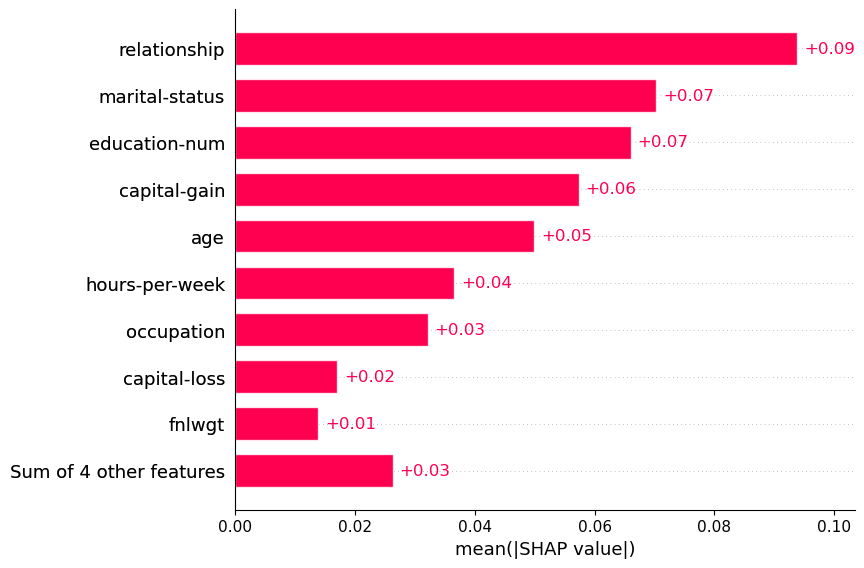

In [20]:
shap.plots.bar(tree_explanation_object[:,:,0])

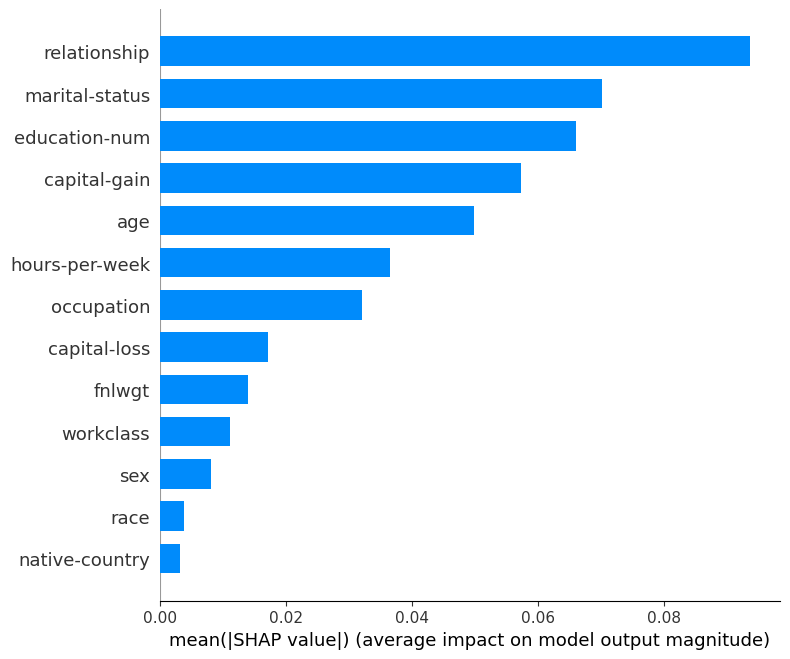

In [21]:
shap.summary_plot(shap_values_tree[0], X_test[0:200], plot_type='bar')

In [22]:
xgb_shap_tree_exp = shap.TreeExplainer(xgbclf)
xgb_shap_values_tree = xgb_shap_tree_exp.shap_values(X_test[0:200])

In [23]:
xgb_shap_values_tree

array([[-0.63132155,  0.03779531, -0.18949649, ..., -0.08588763,
        -0.00428632,  0.00334535],
       [ 0.7906454 ,  0.04464102, -0.2543585 , ..., -0.08225852,
        -0.03795228,  0.9785005 ],
       [ 0.1669631 ,  0.10630625, -0.17543726, ..., -0.09894836,
         0.24776098,  0.02338828],
       ...,
       [ 0.06381416, -0.5378263 , -0.14545816, ..., -0.08615266,
        -0.11675502, -0.00670623],
       [ 0.541742  ,  0.01949574, -0.29396597, ..., -0.08752466,
         0.00297776, -0.01336668],
       [ 0.22798157, -0.41342503, -0.31563655, ..., -0.05929547,
         0.5638092 , -0.00171465]], dtype=float32)

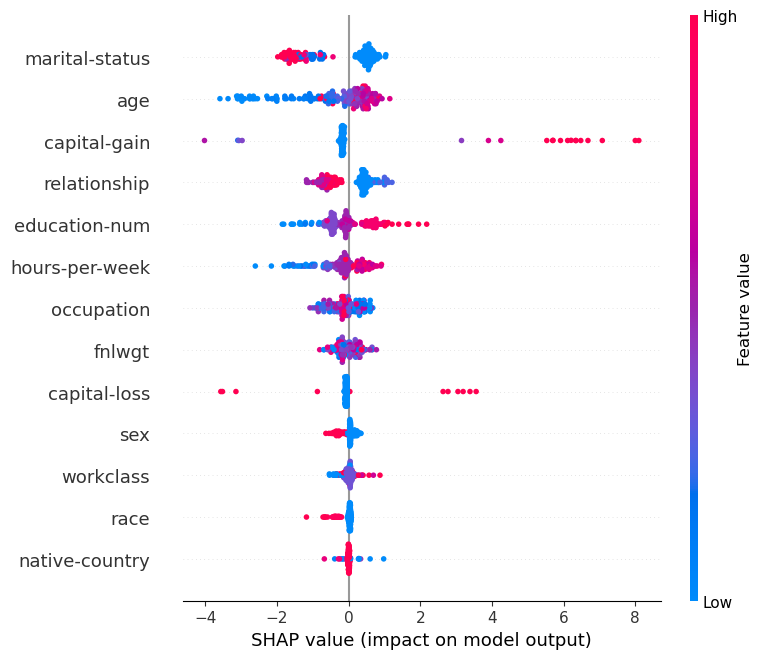

In [24]:
shap.summary_plot(xgb_shap_values_tree, X_test[0:200])

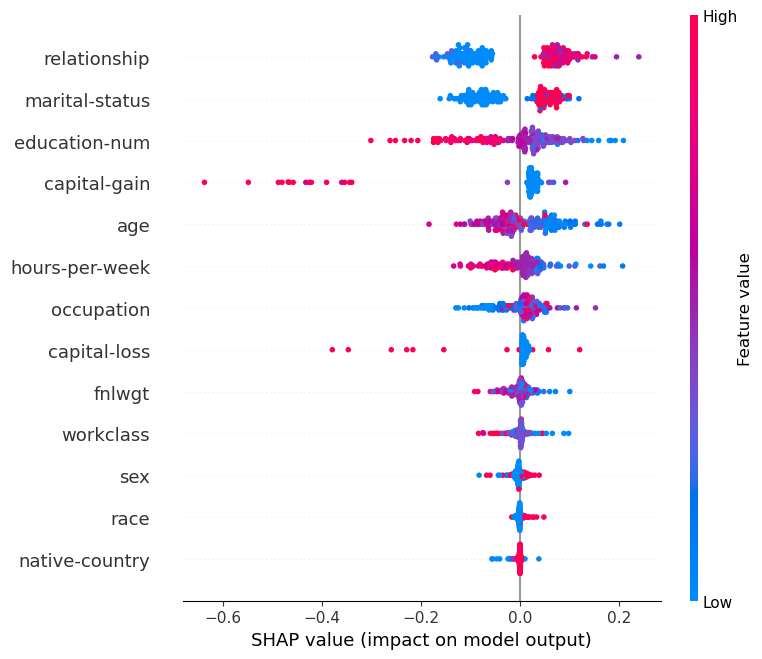

In [25]:
shap.summary_plot(shap_values_tree[0], X_test[0:200])

We can use dependence plot to focus on one variable.

- Each dot is a single prediction (row) from the dataset.
- The x-axis is the value of the feature (from the X matrix).
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.
- The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

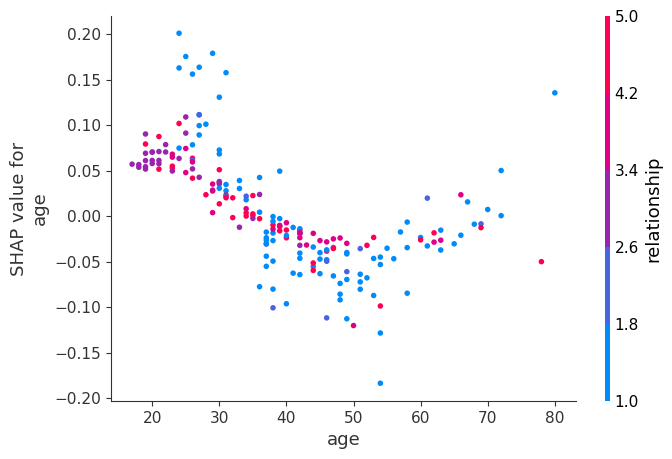

In [26]:
shap.dependence_plot("age", shap_values_tree[0], X_test[0:200])

We can explore the interactions between variables.
SHAP interaction values are a generalization of SHAP values to higher order interactions.
A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

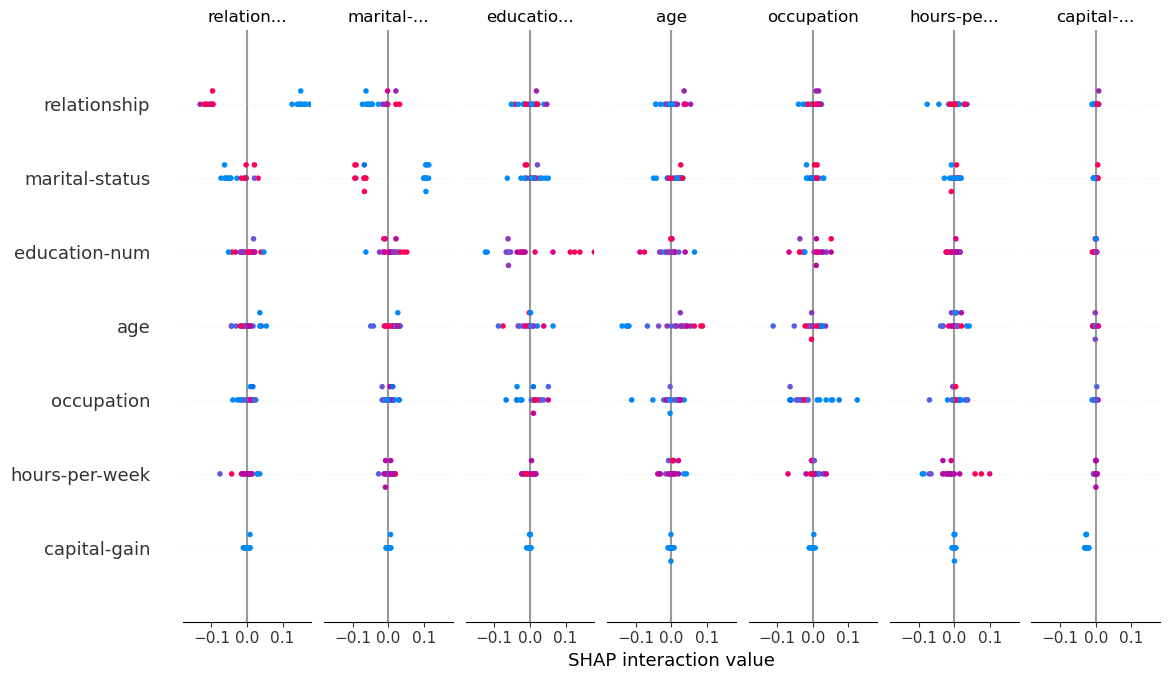

In [27]:
shap_interaction_values_tree = shap_tree_exp.shap_interaction_values(X_test.iloc[0:20])
shap.summary_plot(shap_interaction_values_tree[1], X_test.iloc[0:20])

Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

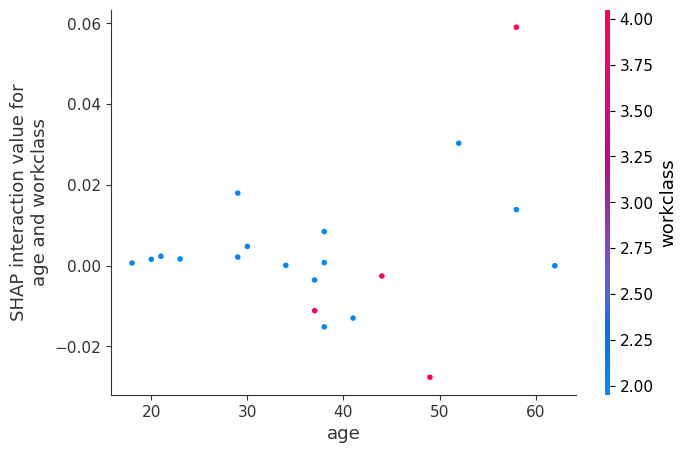

In [28]:
shap.dependence_plot(
    ("age", "workclass"),
    shap_interaction_values_tree[0], X_test.iloc[0:20]
)


SHAP also provides some nice interactive visualizations using javascript

In [29]:
shap.initjs()
shap.force_plot(shap_tree_exp.expected_value[0], shap_values_tree[0], X_test[0:200])

For now we've explored our model on a global level. Let's now look at local explanation using SHAP.

In [30]:
shap.initjs()
shap.force_plot(shap_tree_exp.expected_value[0], shap_values_tree[0][0,:], feature_names)

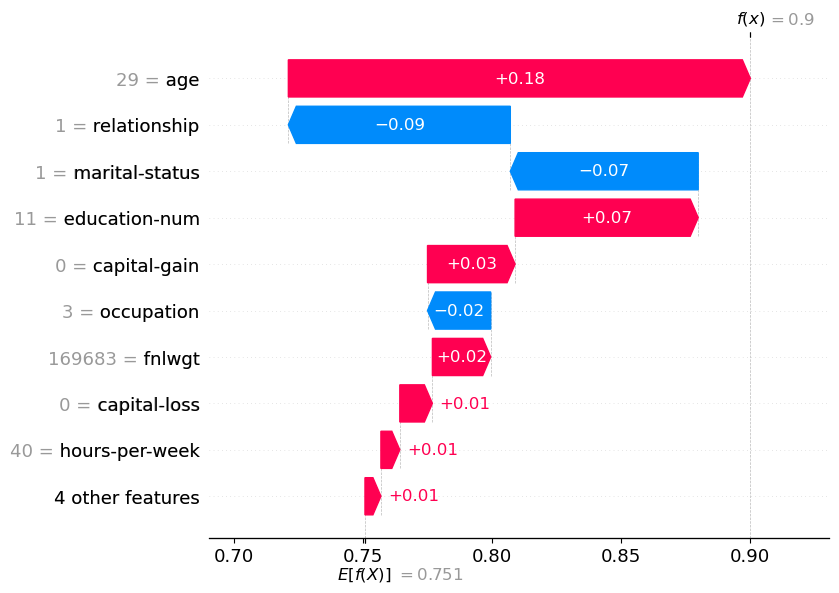

In [31]:
shap.plots.waterfall(tree_explanation_object[:,:,0][0])

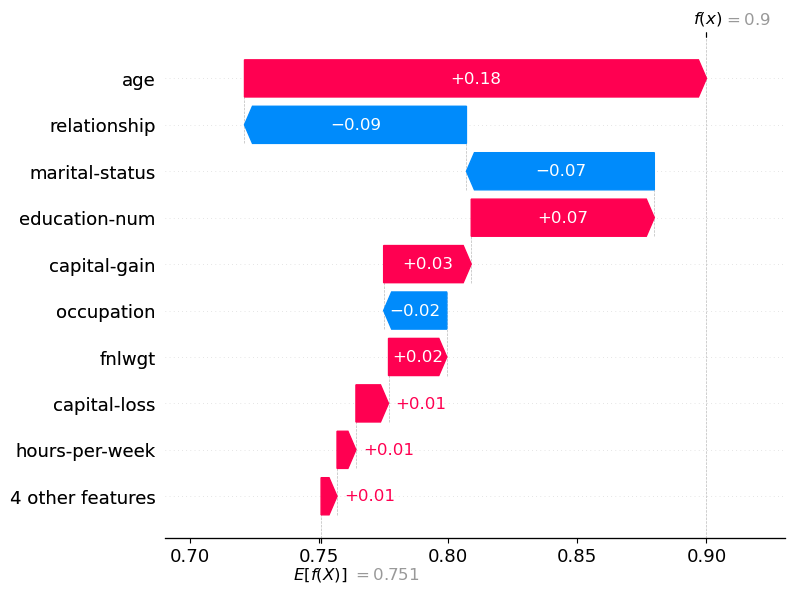

In [32]:
shap.plots._waterfall.waterfall_legacy(shap_tree_exp.expected_value[0], shap_values_tree[0][0,:], feature_names=feature_names)

Another example

Let's try a different explainer: before we used the TreeExplainer, but there are other explainers available in SHAP. Since we are dealing with a RandomForest, another possibility could be the KernelExplainer, that is completley agnostic.

KernelExplainer requires in input the predict_proba of the black-box we want to explain and a sample of the data. In this simple example we use just the first 20 records of the test set, but in principle you can pass whatever representation of your data, such as the centroids obtained from a clustering algorithm.

In [33]:
shap_kernel_exp = shap.KernelExplainer(bb.predict_proba, X_test[0:20])
shap_values_kernel = shap_kernel_exp.shap_values(X_test[0:200])

  0%|          | 0/200 [00:00<?, ?it/s]

Let's now see how the explanation change

In [34]:
shap.initjs()
shap.force_plot(shap_kernel_exp.expected_value[0], shap_values_kernel[0], X_test[0:200])

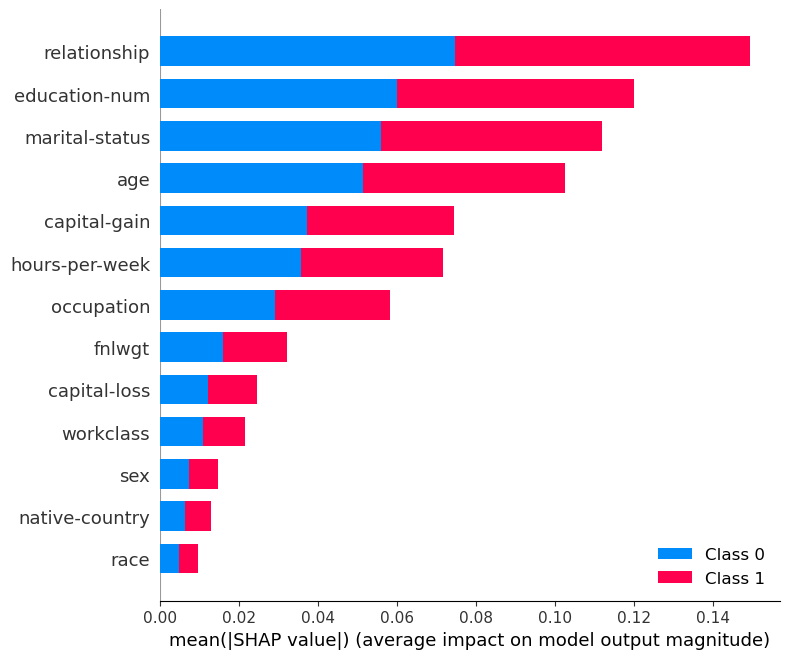

In [35]:
shap.summary_plot(shap_values_kernel, X_test[0:200])

In [36]:
shap.initjs()
shap.force_plot(shap_kernel_exp.expected_value[1], shap_values_kernel[1][1,:], feature_names)

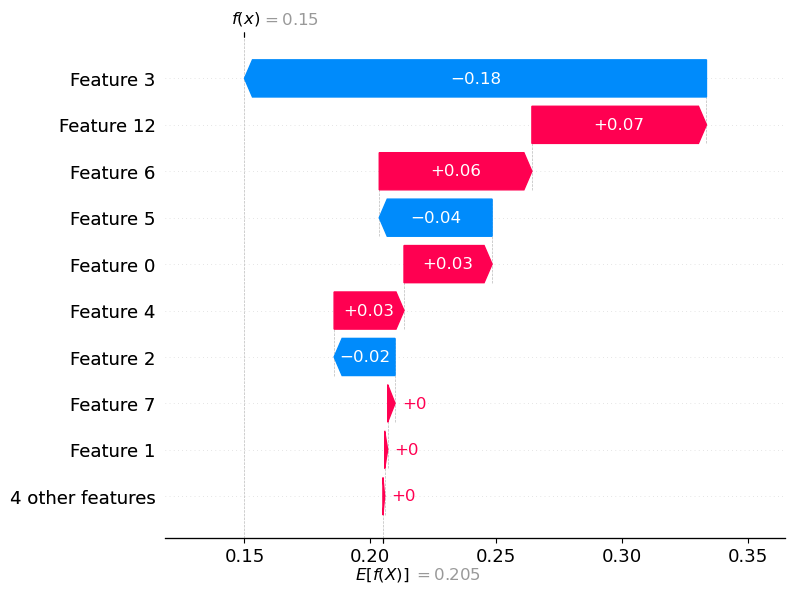

In [37]:
shap.plots._waterfall.waterfall_legacy(shap_kernel_exp.expected_value[1], shap_values_kernel[1][1,:])

# LIME

LIME focuses on local explanations. The idea is: it generates a set of neighbours, on them it trains a linear model. There are 2 kinds of neighbourhood generation:

- Gaussian
- Lhs (Latin Hypercube Sampling)

We first initialize the lime explainer on our train data, providing the names of our features

In [38]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = feature_names)

Then we can explain each data point locally
We can see each explanation from the "perspective" of the class that we want to focus on

In [40]:
exp = explainer.explain_instance(X_test.values[0], bb.predict_proba, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

In [41]:
exp = explainer.explain_instance(X_test.values[0], bb.predict_proba, top_labels=0)
exp.show_in_notebook(show_table=True, show_all=False)

We can also "cut" our explanation and modify the visualization

In [47]:
exp = explainer.explain_instance(X_test.values[0], bb.predict_proba, num_features=5, top_labels=0)
exp.show_in_notebook(show_table=True, show_all=False)

We can provide the explanation as a pyplot figure

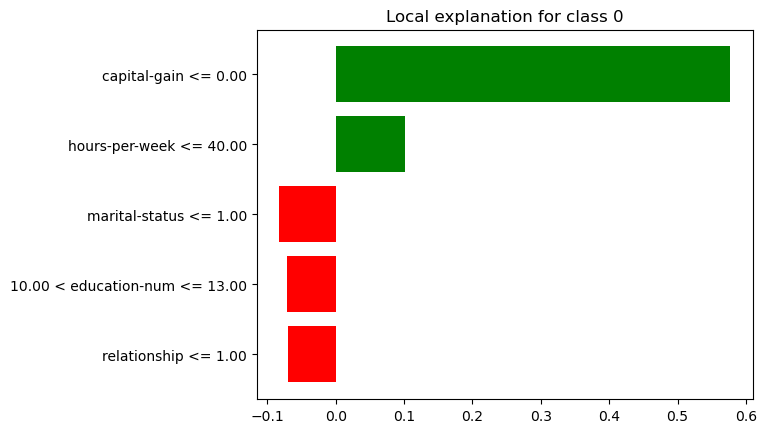

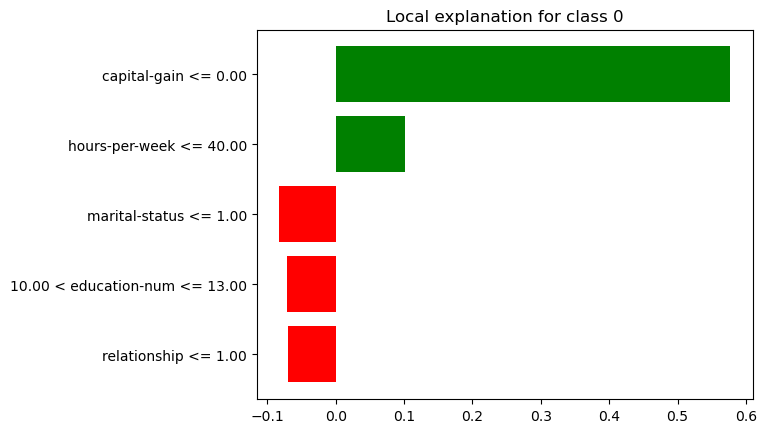

In [43]:
exp.as_pyplot_figure(label=0)

Or manipulate the values as a list

In [44]:
exp.as_list(0)

[('capital-gain <= 0.00', 0.5769454174292533),
 ('hours-per-week <= 40.00', 0.10119451377538509),
 ('marital-status <= 1.00', -0.08231584733129153),
 ('10.00 < education-num <= 13.00', -0.07065375788324539),
 ('relationship <= 1.00', -0.06991006020324847)]

In [49]:
exp.as_map()

{1: [(9, -0.5820610805340426),
  (11, -0.10063638938064755),
  (4, 0.07290634055207217),
  (6, 0.07217444713724674),
  (3, 0.07167101552416175)]}

# Lore

Lore is an algorithm developed internally to the KDDLab. To use it we will use the xai lib that we imported at the beginning. Note that shap and lime are wrappend in the xai lib, so if you want you can replicate the previous part using the xai lib.

We then use the `sklearn_classifier_wrapper` from xai lib to wrap our black box and make it ready to explain

In [50]:
bbox = sklearn_classifier_wrapper(bb) 

Now e could also use the imlpementations of SHAP and Lime that are present in the XAI-lib

In [51]:
explainer = LoreTabularExplainer(bbox)

In [52]:
inst = X_train.iloc[147].values

Lore uses various type of neighborhood generation to provide a local explanation based on factuals and counterfactuals

In [53]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'rndgen', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df, target, config)
exp = explainer.explain(inst)
print(exp)


In [57]:
print('Instance ',inst)
print('True class ',Y_train.iloc[147])
print('Predicted class ',bb.predict(inst.reshape(1, -1)))

Instance  [    58      2 111169      9      2     14      5      1      1      0
      0     40     41]
True class  0
Predicted class  [0]


In [58]:
exp.plotRules()

In [59]:
exp.plotCounterfactualRules()